In [1]:
import qiskit

In [2]:
from qiskit_aer import Aer

--- Starting QD-PCA Attack Simulation with 500 bits ---

--- Post-processing and Key Reconciliation ---

Alice's Final Key (matching bases) : [np.int32(0), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0)]...
Bob's Final Key (matching bases)   : [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]...
Eve's Potential Key (matching bases): [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]...

Total matching bits: 244
Errors in shared key : 103
Detected QBER        : 0.422 (Threshold: 0.11)

⚠️ QBER too high. Attack detected! Alice and Bob will abort key exchange.
The disturbance caused by Eve's cloning was significant enough to be noticed.

--- Plotting QBER Results ---


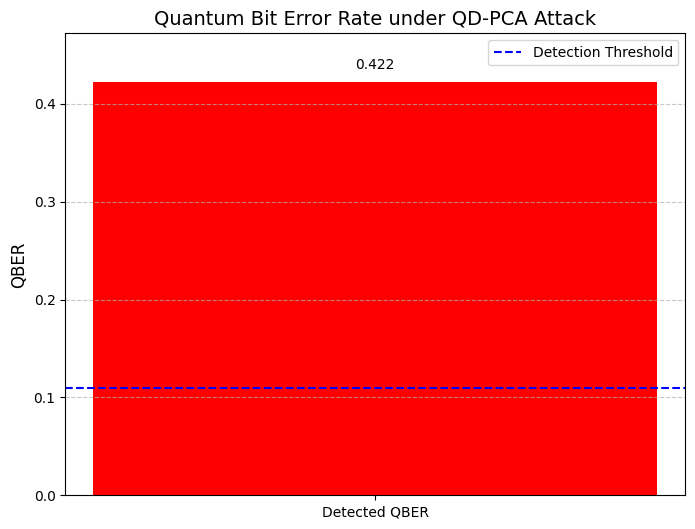

--- Plot Displayed ---

--- Simulation finished in 220.42 seconds ---


In [6]:
# -*- coding: utf-8 -*-
"""
qd_pca_simulation.py

This script simulates a simplified Quantum Key Distribution (QKD)
protocol (BB84) and demonstrates a Quantum Digital Principal Component
Analysis (QD-PCA) attack.

The simulation aims to show how an eavesdropper (Eve) attempting to
clone qubits can introduce a detectable Quantum Bit Error Rate (QBER)
between Alice and Bob's shared key, thus revealing her presence.

Key Concepts:
- BB84 Protocol: A fundamental QKD protocol.
- QBER (Quantum Bit Error Rate): A measure of errors in the quantum channel.
- QD-PCA Attack: An eavesdropping strategy involving approximate cloning.
- Qiskit: Python framework for quantum computing.
- AerSimulator: Qiskit's high-performance local quantum simulator.
"""

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator # Correct import for Aer simulator
import numpy as np
import matplotlib.pyplot as plt
import time # Import the time module for performance measurement

# --- Simulation Parameters ---
# Reduced num_bits for faster execution.
# On a typical system, 500 bits should run in a few seconds.
num_bits = 500  # Simulated number of key bits
qber_threshold = 0.11 # Above this, Bob suspects Eve (typical threshold is ~11%)
cloning_fidelity = 0.833 # Buzek-Hillery cloning fidelity (classical approximation)
disturbance_prob = 0.05 # Probability of Eve's cloning causing a bit flip (simulated)

# --- Helper Functions ---

def generate_bb84_bits(n_bits):
    """
    Generates Alice's random bits and corresponding random bases (0 for Z, 1 for X).

    Args:
        n_bits (int): The number of bits to generate.

    Returns:
        tuple: (bits, bases) numpy arrays.
    """
    bits = np.random.randint(2, size=n_bits)
    bases = np.random.randint(2, size=n_bits) # 0 for Z-basis, 1 for X-basis
    return bits, bases

def encode_qubit(bit, basis):
    """
    Encodes a classical bit into a quantum qubit based on the chosen basis.

    Args:
        bit (int): The classical bit (0 or 1).
        basis (int): The encoding basis (0 for Z, 1 for X).

    Returns:
        QuantumCircuit: A Qiskit QuantumCircuit representing the encoded qubit.
    """
    qc = QuantumCircuit(1, 1) # 1 qubit, 1 classical bit for measurement
    if bit == 1:
        qc.x(0) # Apply X gate if bit is 1
    if basis == 1:
        qc.h(0) # Apply Hadamard if basis is X (superposition)
    return qc

def measure_qubit(qc_to_measure, basis, simulator):
    """
    Measures a quantum qubit in the specified basis.

    Args:
        qc_to_measure (QuantumCircuit): The circuit containing the qubit to measure.
        basis (int): The measurement basis (0 for Z, 1 for X).
        simulator (AerSimulator): The Qiskit Aer simulator instance.

    Returns:
        int: The measured classical bit (0 or 1).
    """
    # Create a new circuit for measurement to avoid modifying the original
    # This is important if qc_to_measure is a copy that needs to be preserved
    # for other parts of the simulation, though here we're just measuring a copy.
    measurement_qc = QuantumCircuit(1, 1)
    measurement_qc.compose(qc_to_measure, inplace=True) # Add the prepared qubit to this circuit

    if basis == 1:
        measurement_qc.h(0) # Apply Hadamard if measuring in X basis
    measurement_qc.measure(0, 0) # Measure qubit 0 into classical bit 0

    # Transpile the circuit for optimal execution on the simulator
    transpiled_qc = transpile(measurement_qc, simulator)

    # Execute the circuit on the simulator
    job = simulator.run(transpiled_qc, shots=1) # Only 1 shot needed for a single measurement
    result = job.result()
    counts = result.get_counts(transpiled_qc) # Get counts for the transpiled circuit

    # Extract the measured bit (e.g., {'0': 1} or {'1': 1})
    # The key of the counts dictionary is the measured bit string
    return int(list(counts.keys())[0])

def qd_pca_attack(original_bit, basis, disturbance_prob):
    """
    Simulates Eve's QD-PCA attack.
    This is a simplified model where Eve's cloning attempt has a
    `disturbance_prob` of flipping the bit that is forwarded to Bob.
    In a real QD-PCA, Eve uses a cloning machine, and the disturbance
    arises from the imperfect cloning process.

    Args:
        original_bit (int): The bit Eve received (after her measurement).
        basis (int): The basis Alice used (not directly used in this simplified
                     classical disturbance model, but kept for conceptual consistency).
        disturbance_prob (float): The probability that Eve's action flips the bit.

    Returns:
        int: The bit that Eve forwards to Bob (potentially disturbed).
    """
    # Simulate disturbance: with a certain probability, Eve's cloning attempt
    # causes a flip in the bit she forwards to Bob.
    if np.random.rand() < disturbance_prob:
        return original_bit ^ 1  # Flip the bit (0 becomes 1, 1 becomes 0)
    return original_bit  # No flip

# --- Main Simulation Logic ---
if __name__ == "__main__":
    start_time = time.time() # Record start time for performance measurement

    # Initialize the Aer simulator once
    simulator = AerSimulator()

    # Alice generates her bits and bases
    alice_bits, alice_bases = generate_bb84_bits(num_bits)

    # Eve and Bob choose their random bases
    eve_bases = np.random.randint(2, size=num_bits)
    bob_bases = np.random.randint(2, size=num_bits)

    # Records to store results
    bob_results = []
    eve_results = []
    matching_indices = [] # Indices where Alice's and Bob's bases match

    print(f"--- Starting QD-PCA Attack Simulation with {num_bits} bits ---")

    for i in range(num_bits):
        # Step 1: Alice prepares and sends qubit
        # Alice encodes her bit into a qubit based on her chosen basis
        alice_qc = encode_qubit(alice_bits[i], alice_bases[i])

        # Step 2: Eve intercepts and performs approximate cloning
        # Eve measures the qubit Alice sent in her (Eve's) chosen basis.
        # We need to copy the circuit to simulate Eve's independent measurement
        # without affecting the original state that would conceptually be
        # passed to Bob (though here we're simulating the *effect* of cloning).
        intercepted_bit_by_eve = measure_qubit(alice_qc.copy(), eve_bases[i], simulator)
        eve_results.append(intercepted_bit_by_eve)

        # Simulate the disturbance caused by Eve's cloning and forwarding
        # This `disturbed_bit` is what Bob effectively receives.
        disturbed_bit_for_bob = qd_pca_attack(intercepted_bit_by_eve, alice_bases[i], disturbance_prob)

        # Step 3: Bob measures the (potentially disturbed) qubit
        # Bob re-encodes the disturbed bit into a qubit (conceptually, he's just
        # receiving a classical bit from Eve's "resend" and preparing his own qubit).
        # Then he measures it in his chosen basis.
        bob_qc_for_measurement = encode_qubit(disturbed_bit_for_bob, 0) # Encode the received bit
        bob_measured_bit = measure_qubit(bob_qc_for_measurement, bob_bases[i], simulator)
        bob_results.append(bob_measured_bit)

        # Step 4: Alice and Bob publicly announce bases and identify matching ones
        if bob_bases[i] == alice_bases[i]:
            matching_indices.append(i)

    print("\n--- Post-processing and Key Reconciliation ---")

    # Post-processing: Alice and Bob form their keys from bits where bases matched
    alice_final_key = [alice_bits[i] for i in matching_indices]
    bob_final_key = [bob_results[i] for i in matching_indices]
    eve_potential_key = [eve_results[i] for i in matching_indices] # What Eve would have if her bases matched Alice's

    # QBER Calculation: Compare Alice's and Bob's shared key bits
    # This reveals the presence of Eve's disturbance.
    errors = sum([a != b for a, b in zip(alice_final_key, bob_final_key)])
    if len(alice_final_key) > 0:
        qber = errors / len(alice_final_key)
    else:
        qber = 0.0
        print("Warning: No matching bases found. QBER cannot be calculated.")

    print(f"\nAlice's Final Key (matching bases) : {alice_final_key[:20]}...") # Show first 20 bits
    print(f"Bob's Final Key (matching bases)   : {bob_final_key[:20]}...") # Show first 20 bits
    print(f"Eve's Potential Key (matching bases): {eve_potential_key[:20]}...") # Show first 20 bits
    print(f"\nTotal matching bits: {len(alice_final_key)}")
    print(f"Errors in shared key : {errors}")
    print(f"Detected QBER        : {qber:.3f} (Threshold: {qber_threshold})")

    # --- Attack Detection ---
    if qber < qber_threshold:
        print("\n🔓 QD-PCA Attack went undetected (QBER below threshold).")
        print("This scenario implies Eve was very subtle or the disturbance_prob is too low.")
    else:
        print("\n⚠️ QBER too high. Attack detected! Alice and Bob will abort key exchange.")
        print("The disturbance caused by Eve's cloning was significant enough to be noticed.")

    # --- Plotting QBER ---
    print("\n--- Plotting QBER Results ---")
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Detected QBER'], [qber], color='red' if qber > qber_threshold else 'green')
    plt.axhline(qber_threshold, color='blue', linestyle='--', label='Detection Threshold')

    # Add QBER value on top of the bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

    plt.title("Quantum Bit Error Rate under QD-PCA Attack", fontsize=14)
    plt.ylabel("QBER", fontsize=12)
    plt.ylim(0, max(qber_threshold + 0.05, qber + 0.05)) # Adjust y-limit dynamically
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print("--- Plot Displayed ---")

    end_time = time.time() # Record end time
    elapsed_time = end_time - start_time
    print(f"\n--- Simulation finished in {elapsed_time:.2f} seconds ---")
